In [134]:
from scipy.optimize import minimize
import math
from random import *
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [135]:
def roundAngle(num):
    n = (num-math.pi/4)/(2*math.pi)
    n = n*8
    n = round(n)%8
    n = int(n*45)
    return n

In [136]:
def classSetup(classx, classy, wallsGrid, numChairs, numTables, tableL, tableW):
    global class_x
    global class_y
    global nChairs
    global nTables
    global tableLength
    global tableWidth
    global table_long
    global table_short
    #table: index 0 is short length, index 1 is long length
    global table
    global walls
    global chairs
    global chair_l
    global tables
    
    global classroom
    global available
    global chair_placement
    global table_placement_ew
    global table_placement_ns
    
    class_x = classx
    class_y = classy
    nChairs = numChairs
    nTables = numTables
    tableLength = tableL
    tableWidth = tableW
    
    if tableLength < tableWidth:
        table_long = tableWidth
        table_short = tableLength
    else:
        table_long = tableLength
        table_short = tableWidth
    table = [int(table_short),int(table_long)]
    walls = []
    chairs = []
    chair_l = 1
    tables = []

    classroom = [[0 for i in range(class_x)] for j in range(class_y)]
    chair_placement = [[1 for i in range(class_x)] for j in range(class_y)]
    available = [[1 for i in range(class_x)] for j in range(class_y)]
    for i in range(class_y):
        chair_placement[i][class_x-1] = 0       
    for j in range(class_x):
        chair_placement[class_y-1][j] = 0  
    table_placement_ns = [[1 for i in range(class_x)] for j in range(class_y)]
    table_placement_ew = [[1 for i in range(class_x)] for j in range(class_y)]
    for i in range(class_y):
        for j in range(class_x):
            if j >= class_x-(table_long-1) or i >= class_y-(table_short-1):
                table_placement_ew[i][j] = 0
    for i in range(class_y):
        for j in range(class_x):
            if j >= class_x-(table_short-1) or i >= class_y-(table_long-1):
                table_placement_ns[i][j] = 0

In [137]:
def addChair(x,y,d):
    global classroom
    global chair_placement
    global table_placement_ew
    global table_placement_ns
    global chairs
    
    available = sum(x1.count(1) for x1 in chair_placement)
    if available <= 0:
        return -1

    #update classroom
    for i in range(y, y+chair_l):
        for j in range(x,x+chair_l):
            classroom[i][j] = 2

    #update table_placement_ns
    for i in range(y-table[1], y+chair_l+1):
        for j in range(x-table[0], x+chair_l+1):
            if i >= 0 and i < class_y and j >= 0 and j < class_x and table_placement_ns[i][j]!=0:
                if i >= y-(table[1]-1) and i < y+chair_l and j >= x-(table[0]-1) and j < x+chair_l:
                    table_placement_ns[i][j] = 0
                else:
                    if j == x+chair_l and i > y-table[1] and i < y+chair_l and(d>=315 or d<=45):
                        table_placement_ns[i][j] = table_placement_ns[i][j] + 1
                    if i == y-table[1] and j > x-table[0] and j < x+chair_l and d>=45 and d<=135:
                        table_placement_ns[i][j] = table_placement_ns[i][j] + 1
                    if j == x-table[0] and i > y-table[1] and i < y+chair_l and d>=135 and d<=225:
                        table_placement_ns[i][j] = table_placement_ns[i][j] + 1
                    if i == y+chair_l and j > x-table[0] and j < x+chair_l and d>=225 and d<=315:
                        table_placement_ns[i][j] = table_placement_ns[i][j] + 1

    #update table_placement_ew
    for i in range(y-table[0], y+chair_l+1):
        for j in range(x-table[1], x+chair_l+1):
            if i >= 0 and i < class_y and j >= 0 and j < class_x and table_placement_ew[i][j]!=0:
                if  i >= y-(table[0]-1) and i < y+chair_l and j >= x-(table[1]-1) and j < x+chair_l:
                    table_placement_ew[i][j] = 0
                else:
                    if j == x+chair_l and i > y-table[0] and i < y+chair_l and(d>=315 or d<=45):
                        table_placement_ew[i][j] = table_placement_ew[i][j] + 1
                    if i == y-table[0] and j > x-table[1] and j < x+chair_l and d>=45 and d<=135:
                        table_placement_ew[i][j] = table_placement_ew[i][j] + 1
                    if j == x-table[1] and i > y-table[0] and i < y+chair_l and d>=135 and d<=225:
                        table_placement_ew[i][j] = table_placement_ew[i][j] + 1
                    if i == y+chair_l and j > x-table[1] and j < x+chair_l and d>=225 and d<=315:
                        table_placement_ew[i][j] = table_placement_ew[i][j] + 1

    #change this
    #update chair_placement
    for i in range(class_y):
        for j in range(class_x):
            if math.sqrt((i-y)**2 + (j-x)**2) < 3:
                chair_placement[i][j] = 0

    #add chair
    chairs.append([x,y,d])

In [138]:
def addTable():
    global classroom
    global table_placement_ew
    global table_placement_ns
    global tables
    
    #find highest position number in table_placeent_ns
    max_ns = 0
    for i in range(class_y-(table[1]-1)):
        for j in range(class_x-(table[0]-1)):
            if table_placement_ns[i][j] > max_ns:
                max_ns = table_placement_ns[i][j]
    #find highest position number in table_placeent_ew
    max_ew = 0
    for i in range(class_y-(table[0]-1)):
        for j in range(class_x-(table[1]-1)):
            if table_placement_ew[i][j] > max_ew:
                max_ew = table_placement_ew[i][j]

    #compare the highest position number in ns and ew
    if (max_ns >= max_ew):
        t = table_placement_ns
        table_x = table[0]
        table_y = table[1]
        m = max_ns
        ns_table = 1
    else:
        t = table_placement_ew
        table_x = table[1]
        table_y = table[0]
        m = max_ew
        ns_table = 0

    #count how many available positions there are for the specific table orientation
    available = sum(x.count(m) for x in t)

    #rng for which position
    num = math.ceil(random()*available)
    #put at that position
    for i in range(class_y-(table_y-1)):
        for j in range(class_x-(table_x-1)):
            if t[i][j] == m:
                num -= 1
            if num == 0:
                x = j
                y = i
                break
        if num == 0:
            break

    #update classroom
    for i in range(y, y+table_y):
        for j in range(x,x+table_x):
            classroom[i][j] = 1

    #update table_placement_ns
    for i in range(y-(table[1]-1), y+table[ns_table]):
        for j in range(x-(table[0]-1), x+table[1-ns_table]):
            if i >= 0 and i < class_y and j >= 0 and j < class_x:
                table_placement_ns[i][j] = 0

    #update table_placement_ew
    for i in range(y-(table[0]-1), y+table[ns_table]):
        for j in range(x-(table[1]-1), x+table[1-ns_table]):
            if i >= 0 and i < class_y and j >= 0 and j < class_x:
                table_placement_ew[i][j] = 0

    #add table
    tables.append([x, y, ns_table])

In [139]:
def addWall(x,y):
    global classroom
    global walls
    global table_placement_ns
    global table_placement_ew
    global available
    
    #update classroom
    classroom[x][y] = 3
    walls.append([x,y])

    #update table_placement_ns
    for i in range(y-(table_long-1), y+1):
        for j in range(x-(table_short-1), x+1):
            if i >= 0 and i < class_y and j >= 0 and j < class_x:
                table_placement_ns[i][j] = 0

    #update table_placement_ew
    for i in range(y-(table_short-1), y+1):
        for j in range(x-(table_long-1), x+1):
            if i >= 0 and i < class_y and j >= 0 and j < class_x:
                table_placement_ew[i][j] = 0

    #update chair_placement
    for i in range(y-chair_l,y+1):
        for j in range(x-chair_l,x+1):
            if(i>=0 and j>=0):
                chair_placement[j][i] = 0
                available[j][i] = 0

In [140]:
def clearRoom():
    global chairs
    global tables
    global walls
    global classroom
    global chair_placement
    global table_placement_ew
    global table_placement_ns
    
    chairs = []
    tables = []
    walls = []
    classroom = [[0 for i in range(class_x)] for j in range(class_y)]
    chair_placement = [[1 for i in range(class_x)] for j in range(class_y)]
    available = [[1 for i in range(class_x)] for j in range(class_y)]
    for i in range(class_y):
        chair_placement[i][class_x-1] = 0       
    for j in range(class_x):
        chair_placement[class_y-1][j] = 0  
    table_placement_ns = [[1 for i in range(class_x)] for j in range(class_y)]
    table_placement_ew = [[1 for i in range(class_x)] for j in range(class_y)]
    for i in range(class_y):
        for j in range(class_x):
            if j >= class_x-(table_long-1) or i >= class_y-(table_short-1):
                table_placement_ew[i][j] = 0
    for i in range(class_y):
        for j in range(class_x):
            if j >= class_x-(table_short-1) or i >= class_y-(table_long-1):
                table_placement_ns[i][j] = 0

In [141]:
def optimizerSetup():
    global fstudents
    global bnds
    global cons
    global guess
    global fstudents
    
    bnds = ()
    cons = []
    guess = []
    #fake students prevent students from facing the wall
    r = 4
    fstudents = []
    
    for i in range(0,class_x-chair_l+1,2):
        fstudents.append(i)
        fstudents.append(-r)
        fstudents.append(i)
        fstudents.append(class_y-chair_l+r)
    for i in range(0,class_y-chair_l+1,2):
        fstudents.append(-r)
        fstudents.append(i)
        fstudents.append(class_x-chair_l+r)
        fstudents.append(i)
    for i in range(1,r):
        fstudents.append(class_x-chair_l+i)
        fstudents.append(-r+i)
        fstudents.append(class_x-chair_l+r-i)
        fstudents.append(class_y-chair_l+i)
        fstudents.append(-i)
        fstudents.append(class_y-chair_l+r-i)
        fstudents.append(-r+i)
        fstudents.append(-i)
    
    x_bnd = (0,class_x-2)
    y_bnd = (0,class_y-2)
    d_bnd = (0,4*math.pi)
    for i in range(nChairs):
        bnds = bnds + (x_bnd,y_bnd,d_bnd)

    for i in range(nChairs):
        xtemp = random()*(class_x-1)
        ytemp = random()*(class_y-1)
        while(available[round(ytemp)][round(xtemp)] == 0):
            xtemp = random()*(class_x-1)
            ytemp = random()*(class_y-1)

        guess.append(xtemp)
        guess.append(ytemp)
        guess.append(2*math.pi)

In [142]:
def solve():
    global sol
    
    sol = minimize(objective,guess,args=(class_x,class_y,chair_l,fstudents,available),method='SLSQP',\
                bounds=bnds,constraints=cons)

In [143]:
def objective(z, class_x, class_y, chair_l, fstudents, available):
    #minimize p
    p = 0
    for i in range(int(len(z)/3)):
        x1 = z[i*3]
        y1 = z[i*3+1]
        d1 = z[i*3+2]

        #real to unavailable space in classroom
        for i in range(int(len(available))):
            for j in range(int(len(available[0]))):
                if available[i][j] == 0:
                    x2 = i
                    y2 = j

                    x = x2-x1
                    y = x2-x1

                    p = p + 1000*2**(-1.5*(x**2+y**2))

        #real to fake students
        for j in range(int(len(fstudents)/2)):
            x2 = fstudents[j*2]
            y2 = fstudents[j*2+1]

            #depends on angle of first student
            x = (x2-x1)*math.cos(d1)-(y2-y1)*math.sin(d1)
            y = (x2-x1)*math.sin(d1)+(y2-y1)*math.cos(d1)

            p = p + 8*2**(-.3*(x**2+y**2)) +5*2**(-.1*((x-2)**2+(y-2)**2))
            p = p + 2*2**(-.1*((x-5)**2+(y-5)**2))

        #real to real students    
        for j in range(int(len(z)/3)):
            if i != j:
                #equation
                x2 = z[j*3]
                y2 = z[j*3+1]

                #depends on angle of first student
                x = (x2-x1)*math.cos(d1)-(y2-y1)*math.sin(d1)
                y = (x2-x1)*math.sin(d1)+(y2-y1)*math.cos(d1)

                p = p + 8*2**(-.3*(x**2+y**2)) +5*2**(-.1*((x-2)**2+(y-2)**2))
                p = p + 2*2**(-.1*((x-5)**2+(y-5)**2))
    return p

In [144]:
def solutionIntoClass(sol):
    for i in range(nChairs):
        if (addChair(int(round(sol.x[i*3])),int(round(sol.x[i*3+1])),roundAngle(sol.x[i*3+2])) == -1):
            print("Not enough space!")
    for i in range(nTables):
        if (addTable() == -1):
            print("Not enough space!")

In [145]:
wallExample = [
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,1],
    [0,0,0,0,0,0,0,0,1,1]
]

classSetup(classx=10,classy=11,wallsGrid=wallExample,numChairs=3,numTables=0,tableL=6,tableW=2)
optimizerSetup()
solve()
solutionIntoClass(sol)

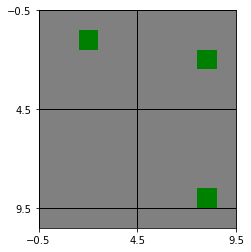

[8, 2, 225]
[8, 9, 135]
[2, 1, 270]


In [146]:
def debugClassroom():
    print("Classroom:", end = "\n")
    for i in range(class_y):
        print(classroom[i], end = "\n")
    print("\n")
    
def showClassroom():
    # create discrete colormap
    cmap = colors.ListedColormap(['grey','blue','green','red'])
    bounds = [0,1,2,3,4]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(classroom, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(-.5, class_x, 5))
    ax.set_yticks(np.arange(-.5, class_y, 5))

    plt.show()
    
showClassroom()
for chair in chairs:
    print(chair)

In [147]:
for i in range(class_y):
    print(table_placement_ns[i], end = "\n")
print("\n")
for i in range(class_y):
    print(table_placement_ew[i], end = "\n")
print("\n")

[1, 0, 0, 1, 1, 1, 2, 0, 0, 0]
[1, 0, 0, 1, 1, 1, 2, 0, 0, 0]
[1, 2, 2, 1, 1, 1, 2, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 3, 3, 0]
[1, 1, 1, 1, 1, 1, 2, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2, 3, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 2, 2, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 2, 2, 0, 0, 0, 0, 0]
[1, 1, 2, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 2, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]




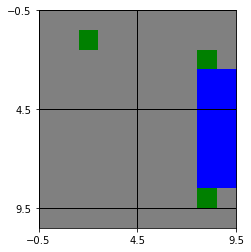

In [148]:
addTable()
showClassroom()